In [ ]:
!pip install -r requirements.txt
!pip install ultralytics timm scikit-learn faiss-cpu tdqm

  Using cached logging-0.4.9.6.tar.gz (96 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


ERROR: Could not find a version that satisfies the requirement faiss (from versions: none)
ERROR: No matching distribution found for faiss


In [ ]:
from inference import EmbeddingClassifier
import cv2
import numpy as np
import json
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging


In [26]:
config = {
    "dataset": {
        "path": "database.pt"
    },
    "model": {
        "path": "model.ckpt",
        "device": "cpu"   # or "cuda" if your env supports it
    },
    "log_level": "INFO"
}

IMAGES_DIR = "../data_images/"
DATA_DIR = "../data_csv/"
RESULTS_DIR = "../results/"

logging.getLogger().setLevel(logging.CRITICAL)


In [5]:
fishial_path = os.path.join(DATA_DIR, "fishial_V7.csv") # Fishial's species for V7
timor_leste_data_path = os.path.join(DATA_DIR, "timor-leste.csv") # Annotation info for ground truth

# Data preparation

In [6]:
with open("labels.json", "r") as f:
    labels = json.load(f)

valid_species = set(labels.keys())

In [7]:
# Filter for relevant species 
df_tl_ann = pd.read_csv(timor_leste_data_path, encoding="utf-8-sig", header=0, skiprows=1)
df_tl_ann["Species_name"] = df_tl_ann["Species_name"].astype(str).str.strip()

df_filtered = df_tl_ann[df_tl_ann["Species_name"].isin(valid_species)]
image_list = df_filtered["image_file"].tolist()

print(f"Number of images after filtering for relevant species: {len(image_list)}")

Number of images after filtering for relevant species: 193


# Model

In [12]:
y_true = []
y_pred = []
used_images = []   # keep track of which images we actually classified
N = 3

classifier = EmbeddingClassifier(config)
logging.getLogger("classifier").setLevel(logging.CRITICAL)


for i in range(len(image_list)):
    img_name = image_list[i]
    species_rows = df_filtered.loc[df_filtered["image_file"] == img_name, "Species_name"]

    if species_rows.empty:
        print(f"No GT found in df_filtered for {img_name}, skipping.")
        continue

    species = species_rows.values[0]  # ground truth

    image_path = os.path.join(IMAGES_DIR, img_name)
    print(f"\n--- Classifying image {i+1}: {img_name} ---")

    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read: {image_path}")
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = classifier(img)

    if not results:
        print("No predictions returned, skipping.")
        continue

    # top-1 prediction
    top1 = results[0]

    print("Top predictions:")
    for pred in results:
        print(f"{pred.name}   | accuracy: {pred.accuracy:.3f}")

    # store for later comparison
    y_true.append(species)
    y_pred.append(top1.name)
    used_images.append(img_name)


[2025-11-21 19:47:59] [INFO] - Dataset loaded from database.pt
[2025-11-21 19:48:02] [INFO] - Initializing EmbeddingClassifier...


Loading ViT backbone: beitv2_base_patch16_224.in1k_ft_in22k_in1k
StableEmbeddingModel initialized with ViT backbone: beitv2_base_patch16_224.in1k_ft_in22k_in1k
  Embedding Dim: 512, Num Classes: 639
  ArcFace s: 64.0, m: 0.5
  Backbone out features (ViT embed_dim): 768
  BN in embedding: False, Dropout in embedding: 0.11


[2025-11-21 19:48:03] [INFO] - Torch model loaded from model.ckpt
[2025-11-21 19:48:03] [INFO] - EmbeddingClassifier initialized successfully.
[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings



--- Classifying image 1: 1689120590238.jpg ---


[2025-11-21 19:48:04] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:04] [INFO] - Completed in 0.01 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.100
Caranx crysos   | accuracy: 0.159

--- Classifying image 2: 1689388044927.jpg ---
Top predictions:
Caranx ignobilis   | accuracy: 0.817
Caranx sexfasciatus   | accuracy: 0.821

--- Classifying image 3: 1689388326411.jpg ---


[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:04] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:04] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx lugubris   | accuracy: 0.813
Caranx sexfasciatus   | accuracy: 0.810
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 4: 1689577829534.jpg ---
Top predictions:
Scomberomorus commerson   | accuracy: 0.903
Scomberomorus cavalla   | accuracy: 0.100

--- Classifying image 5: 1689577974563.jpg ---


[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:04] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:04] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:04] [INFO] - Completed in 0.00 seconds


Top predictions:
Scomberomorus cavalla   | accuracy: 0.943
Scomberomorus commerson   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 6: 1689594468820.jpg ---
Top predictions:
Ariopsis felis   | accuracy: 0.557

--- Classifying image 7: 1689651076768.jpg ---


[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:05] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:05] [INFO] - Completed in 0.02 seconds


Top predictions:
Xiphias gladius   | accuracy: 0.850

--- Classifying image 8: 1689651811316.jpg ---


[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:05] [INFO] - Completed in 0.01 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.902
Scomberomorus cavalla   | accuracy: 0.939
Scomberomorus commerson   | accuracy: 0.900

--- Classifying image 9: 1689652491689.jpg ---
Top predictions:
Scomberomorus cavalla   | accuracy: 0.968
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 10: 1689733035992.jpg ---


[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:05] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:05] [INFO] - Completed in 0.02 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.923

--- Classifying image 11: 1689739881340.jpg ---


[2025-11-21 19:48:05] [INFO] - Starting search over 1 embeddings


Top predictions:
Makaira nigricans   | accuracy: 0.845
Kajikia audax   | accuracy: 0.838
Istiophorus albicans   | accuracy: 0.830
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 12: 1689739901296.jpg ---


[2025-11-21 19:48:05] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:06] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:06] [INFO] - Completed in 0.01 seconds


Top predictions:
Scomberomorus cavalla   | accuracy: 0.942
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 13: 1689740066618.jpg ---
Top predictions:
Scomberomorus commerson   | accuracy: 0.964

--- Classifying image 14: 1689740260887.jpg ---


[2025-11-21 19:48:06] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:06] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:06] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:06] [INFO] - Completed in 0.02 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.806
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 15: 1689743257346.jpg ---
Top predictions:
Acanthocybium solandri   | accuracy: 0.874
Scomberomorus commerson   | accuracy: 0.100

--- Classifying image 16: 1690337039741.jpg ---


[2025-11-21 19:48:06] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:06] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:06] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:06] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx sexfasciatus   | accuracy: 0.809
Caranx latus   | accuracy: 0.100
Nematistius pectoralis   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 17: 1690349481994.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.808

--- Classifying image 18: 1690349481994.jpg ---


[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:07] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:07] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx hippos   | accuracy: 0.808

--- Classifying image 19: 1690466885625.jpg ---


[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings


Top predictions:
Caranx ignobilis   | accuracy: 0.887
Caranx sexfasciatus   | accuracy: 0.100
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 20: 1690544392983.jpg ---


[2025-11-21 19:48:07] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:07] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx bartholomaei   | accuracy: 0.843

--- Classifying image 21: 1690544392983.jpg ---
Top predictions:
Caranx bartholomaei   | accuracy: 0.843

--- Classifying image 22: 1690598682706.jpg ---


[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:07] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:07] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:07] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.683
Rhomboplites aurorubens   | accuracy: 0.222

--- Classifying image 23: 1690599089156.jpg ---
Top predictions:
Lutjanus analis   | accuracy: 0.835

--- Classifying image 24: 1690599089156.jpg ---


[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus analis   | accuracy: 0.835

--- Classifying image 25: 1690890877921.jpg ---
Top predictions:
Epinephelus fasciatus   | accuracy: 0.379
Carassius auratus   | accuracy: 0.274

--- Classifying image 26: 1690890877921.jpg ---


[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.01 seconds


Top predictions:
Epinephelus fasciatus   | accuracy: 0.379
Carassius auratus   | accuracy: 0.274

--- Classifying image 27: 1691143949361.jpg ---
Top predictions:
Caranx lugubris   | accuracy: 0.892
Caranx melampygus   | accuracy: 0.100

--- Classifying image 28: 1691197797009.jpg ---


[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:08] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:08] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx hippos   | accuracy: 0.100
Caranx sexfasciatus   | accuracy: 0.187

--- Classifying image 29: 1691197797009.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.100
Caranx sexfasciatus   | accuracy: 0.187

--- Classifying image 30: 1691201510682.jpg ---


[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.918

--- Classifying image 31: 1691201635655.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.803
Lutjanus rivulatus   | accuracy: 0.100

--- Classifying image 32: 1691201728522.jpg ---


[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.100

--- Classifying image 33: 1691234458029.jpg ---
Top predictions:
Elagatis bipinnulata   | accuracy: 0.962
Seriola lalandi   | accuracy: 0.100

--- Classifying image 34: 1691235083249.jpg ---


[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:09] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:09] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.933

--- Classifying image 35: 1691235144639.jpg ---
Top predictions:
Caranx hippos   | accuracy: 0.100
Thunnus albacares   | accuracy: 0.171
Bagre marinus   | accuracy: 0.158

--- Classifying image 36: 1691235476798.jpg ---


[2025-11-21 19:48:10] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:10] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:10] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:10] [INFO] - Completed in 0.01 seconds


Top predictions:
Xiphias gladius   | accuracy: 0.813
Thunnus albacares   | accuracy: 0.379

--- Classifying image 37: 1691235509689.jpg ---


[2025-11-21 19:48:10] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:10] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.828
Caranx sexfasciatus   | accuracy: 0.100

--- Classifying image 38: 1691235988859.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.856
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 39: 1691236115459.jpg ---


[2025-11-21 19:48:10] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:10] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:10] [INFO] - Starting search over 1 embeddings


Top predictions:
Thunnus albacares   | accuracy: 0.856
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 40: 1692330985857.jpg ---


[2025-11-21 19:48:10] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:11] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:11] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx crysos   | accuracy: 0.841

--- Classifying image 41: 1692330985857.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.841

--- Classifying image 42: 1692413225981.jpg ---


[2025-11-21 19:48:11] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:11] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.859

--- Classifying image 43: 1692413842219.jpg ---


[2025-11-21 19:48:11] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:11] [INFO] - Completed in 0.00 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.860

--- Classifying image 44: 1692414093710.jpg ---


[2025-11-21 19:48:11] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:11] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:11] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:11] [INFO] - Completed in 0.00 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.860
Lutjanus campechanus   | accuracy: 0.109

--- Classifying image 45: 1692414486273.jpg ---
No predictions returned, skipping.

--- Classifying image 46: 1692581137223.jpg ---


[2025-11-21 19:48:12] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:12] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.948
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 47: 1692581157271.jpg ---


[2025-11-21 19:48:12] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:12] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.941
Alectis ciliaris   | accuracy: 0.100

--- Classifying image 48: 1693045597639.jpg ---


[2025-11-21 19:48:12] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:12] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:12] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus campechanus   | accuracy: 0.611
Diplodus capensis   | accuracy: 0.101

--- Classifying image 49: 1693045767461.jpg ---


[2025-11-21 19:48:12] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:12] [INFO] - Starting search over 1 embeddings


Top predictions:
Scomber scombrus   | accuracy: 0.829
Euthynnus alletteratus   | accuracy: 0.816
Scomber japonicus   | accuracy: 0.812

--- Classifying image 50: 1693045954991.jpg ---


[2025-11-21 19:48:12] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:13] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:13] [INFO] - Completed in 0.01 seconds


Top predictions:
Scomber scombrus   | accuracy: 0.688
Euthynnus alletteratus   | accuracy: 0.228

--- Classifying image 51: 1693046054194.jpg ---


[2025-11-21 19:48:13] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:13] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 52: 1693046054194.jpg ---
Top predictions:
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 53: 1693046250037.jpg ---


[2025-11-21 19:48:13] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:13] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:13] [INFO] - Starting search over 1 embeddings


Top predictions:
Caranx crysos   | accuracy: 0.813

--- Classifying image 54: 1693046250037.jpg ---


[2025-11-21 19:48:13] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:13] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:13] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx crysos   | accuracy: 0.813

--- Classifying image 55: 1693046470745.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.611
Diplodus capensis   | accuracy: 0.101

--- Classifying image 56: 1693046578401.jpg ---


[2025-11-21 19:48:14] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:14] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:14] [INFO] - Starting search over 1 embeddings


Top predictions:
Scomber scombrus   | accuracy: 0.812
Scomber japonicus   | accuracy: 0.100

--- Classifying image 57: 1693046853848.jpg ---


[2025-11-21 19:48:14] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:14] [INFO] - Starting search over 1 embeddings


No predictions returned, skipping.

--- Classifying image 58: 1693444885638.jpg ---


[2025-11-21 19:48:14] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:14] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:14] [INFO] - Completed in 0.02 seconds


Top predictions:
Scomberomorus commerson   | accuracy: 0.945
Scomberomorus cavalla   | accuracy: 0.100

--- Classifying image 59: 1693450624018.jpg ---


[2025-11-21 19:48:14] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:14] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx hippos   | accuracy: 0.818
Caranx caninus   | accuracy: 0.100
Selene vomer   | accuracy: 0.100

--- Classifying image 60: 1693535715149.jpg ---


[2025-11-21 19:48:15] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:15] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx hippos   | accuracy: 0.835
Caranx caninus   | accuracy: 0.855
Caranx ignobilis   | accuracy: 0.823

--- Classifying image 61: 1693546581340.jpg ---


[2025-11-21 19:48:15] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:15] [INFO] - Completed in 0.01 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.863
Selene vomer   | accuracy: 0.100

--- Classifying image 62: 1693546778635.jpg ---
Top predictions:
Makaira nigricans   | accuracy: 0.100
Xiphias gladius   | accuracy: 0.100

--- Classifying image 63: 1693549640994.jpg ---


[2025-11-21 19:48:15] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:15] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:15] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:15] [INFO] - Completed in 0.00 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.801
Selene vomer   | accuracy: 0.124

--- Classifying image 64: 1693652276403.jpg ---
Top predictions:
Gymnosarda unicolor   | accuracy: 0.594
Katsuwonus pelamis   | accuracy: 0.245

--- Classifying image 65: 1694346646225.jpg ---


[2025-11-21 19:48:15] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:15] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:16] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:16] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx sexfasciatus   | accuracy: 0.939
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 66: 1694865793188.jpg ---
Top predictions:
Lutjanus bohar   | accuracy: 0.832

--- Classifying image 67: 1694867305294.jpg ---


[2025-11-21 19:48:16] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:16] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:16] [INFO] - Starting search over 1 embeddings


Top predictions:
Belone belone   | accuracy: 0.564

--- Classifying image 68: 1694867312901.jpg ---


[2025-11-21 19:48:16] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:16] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:16] [INFO] - Completed in 0.01 seconds


Top predictions:
Belone belone   | accuracy: 0.703

--- Classifying image 69: 1695258772293.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.831

--- Classifying image 70: 1695267680911.jpg ---


[2025-11-21 19:48:16] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:16] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:17] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:17] [INFO] - Completed in 0.01 seconds


Top predictions:
Clupea harengus   | accuracy: 0.640
Salvelinus namaycush   | accuracy: 0.152

--- Classifying image 71: 1695388917511.jpg ---
Top predictions:
Katsuwonus pelamis   | accuracy: 0.981
Sarda sarda   | accuracy: 0.100

--- Classifying image 72: 1695389182703.jpg ---


[2025-11-21 19:48:17] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:17] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:17] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:17] [INFO] - Completed in 0.01 seconds


Top predictions:
Katsuwonus pelamis   | accuracy: 0.973
Sarda sarda   | accuracy: 0.100

--- Classifying image 73: 1695389254664.jpg ---


[2025-11-21 19:48:17] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:17] [INFO] - Completed in 0.02 seconds


Top predictions:
Katsuwonus pelamis   | accuracy: 0.973
Sarda sarda   | accuracy: 0.100

--- Classifying image 74: 1695389712651.jpg ---


[2025-11-21 19:48:17] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:17] [INFO] - Completed in 0.02 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Thunnus alalunga   | accuracy: 0.100

--- Classifying image 75: 1695389756695.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Thunnus alalunga   | accuracy: 0.100

--- Classifying image 76: 1695390143732.jpg ---


[2025-11-21 19:48:18] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:18] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:18] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:18] [INFO] - Completed in 0.02 seconds


Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 77: 1695390161790.jpg ---


[2025-11-21 19:48:18] [INFO] - Starting search over 1 embeddings


Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 78: 1695390184818.jpg ---


[2025-11-21 19:48:18] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:18] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:18] [INFO] - Completed in 0.00 seconds


Top predictions:
Istiophorus albicans   | accuracy: 0.851
Makaira nigricans   | accuracy: 0.846
Kajikia audax   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.201

--- Classifying image 79: 1695511150791.jpg ---
Top predictions:
Thunnus albacares   | accuracy: 0.190
Ariopsis felis   | accuracy: 0.157
Caranx bartholomaei   | accuracy: 0.132
Seriola dumerili   | accuracy: 0.110

--- Classifying image 80: 1695511964208.jpg ---


[2025-11-21 19:48:18] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:18] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings


Top predictions:
Hoplias malabaricus   | accuracy: 0.993

--- Classifying image 81: 1695521758525.jpg ---


[2025-11-21 19:48:19] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:19] [INFO] - Completed in 0.01 seconds


Top predictions:
Ariopsis felis   | accuracy: 0.379
Caranx sexfasciatus   | accuracy: 0.311
Clarias gariepinus   | accuracy: 0.141

--- Classifying image 82: 1695691830697.jpg ---
Top predictions:
Lutjanus gibbus   | accuracy: 0.100
Lutjanus mahogoni   | accuracy: 0.100

--- Classifying image 83: 1695713427558.jpg ---


[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:19] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:19] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus mahogoni   | accuracy: 0.100
Amphilophus citrinellus   | accuracy: 0.304
Lutjanus gibbus   | accuracy: 0.102

--- Classifying image 84: 1695734455651.jpg ---
Top predictions:
Elagatis bipinnulata   | accuracy: 0.282
Hypanus americanus   | accuracy: 0.271
Ocyurus chrysurus   | accuracy: 0.128

--- Classifying image 85: 1695734906095.jpg ---


[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:19] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:19] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:19] [INFO] - Completed in 0.02 seconds


Top predictions:
Acanthocybium solandri   | accuracy: 0.931
Kajikia audax   | accuracy: 0.931

--- Classifying image 86: 1695735175273.jpg ---


[2025-11-21 19:48:20] [INFO] - Starting search over 1 embeddings


Top predictions:
Scomberomorus commerson   | accuracy: 0.904
Scomberomorus cavalla   | accuracy: 0.100
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 87: 1695735361459.jpg ---


[2025-11-21 19:48:20] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:20] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:20] [INFO] - Completed in 0.01 seconds


Top predictions:
Scarus coeruleus   | accuracy: 0.203

--- Classifying image 88: 1695735670368.jpg ---


[2025-11-21 19:48:20] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:20] [INFO] - Completed in 0.01 seconds


Top predictions:
Scomberomorus cavalla   | accuracy: 0.817
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 89: 1695735670368.jpg ---


[2025-11-21 19:48:20] [INFO] - Starting search over 1 embeddings


Top predictions:
Scomberomorus cavalla   | accuracy: 0.817
Acanthocybium solandri   | accuracy: 0.100

--- Classifying image 90: 1696333279652.jpg ---


[2025-11-21 19:48:20] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:20] [INFO] - Starting search over 1 embeddings


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus vivanus   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.255

--- Classifying image 91: 1696335870241.jpg ---


[2025-11-21 19:48:20] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus jocu   | accuracy: 0.334
Lutjanus analis   | accuracy: 0.294

--- Classifying image 92: 1696496895174.jpg ---


[2025-11-21 19:48:21] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:21] [INFO] - Completed in 0.00 seconds


Top predictions:
Hiodon alosoides   | accuracy: 0.318
Pachymetopon blochii   | accuracy: 0.162
Hypophthalmichthys molitrix   | accuracy: 0.140
Anisotremus surinamensis   | accuracy: 0.119

--- Classifying image 93: 1696677986326.jpg ---


[2025-11-21 19:48:21] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:21] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:21] [INFO] - Starting search over 1 embeddings


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 94: 1696677986326.jpg ---


[2025-11-21 19:48:21] [INFO] - Completed in 0.02 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 95: 1696945542849.jpg ---


[2025-11-21 19:48:21] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:21] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:21] [INFO] - Starting search over 1 embeddings


Top predictions:
Ictalurus punctatus   | accuracy: 0.100
Ameiurus catus   | accuracy: 0.100
Ameiurus nebulosus   | accuracy: 0.138
Ictalurus furcatus   | accuracy: 0.120

--- Classifying image 96: 1696946750249.jpg ---


[2025-11-21 19:48:21] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:22] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:22] [INFO] - Completed in 0.02 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.862

--- Classifying image 97: 1696947493558.jpg ---


[2025-11-21 19:48:22] [INFO] - Starting search over 1 embeddings


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 98: 1696947493558.jpg ---


[2025-11-21 19:48:22] [INFO] - Completed in 0.02 seconds


Top predictions:
Thunnus albacares   | accuracy: 0.820
Thunnus atlanticus   | accuracy: 0.812
Thunnus thynnus   | accuracy: 0.815

--- Classifying image 99: 1697005652932.jpg ---


[2025-11-21 19:48:22] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:22] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:22] [INFO] - Starting search over 1 embeddings


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Rutilus rutilus   | accuracy: 0.466

--- Classifying image 100: 1697012766699.jpg ---


[2025-11-21 19:48:22] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:22] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus campechanus   | accuracy: 0.868

--- Classifying image 101: 1697114382541.jpg ---


[2025-11-21 19:48:23] [INFO] - Completed in 0.02 seconds


Top predictions:
Caranx ignobilis   | accuracy: 0.822
Alectis ciliaris   | accuracy: 0.100
Caranx crysos   | accuracy: 0.196

--- Classifying image 102: 1697114451439.jpg ---


[2025-11-21 19:48:23] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:23] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:23] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:23] [INFO] - Completed in 0.01 seconds


Top predictions:
Amphilophus citrinellus   | accuracy: 0.431
Rhomboplites aurorubens   | accuracy: 0.238

--- Classifying image 103: 1697114533401.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.806
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 104: 1697115180424.jpg ---


[2025-11-21 19:48:23] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:23] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:23] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:23] [INFO] - Completed in 0.00 seconds


Top predictions:
Seriola dumerili   | accuracy: 0.635

--- Classifying image 105: 1697115186816.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.639

--- Classifying image 106: 1697115495415.jpg ---


[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.00 seconds


Top predictions:
Seriola dumerili   | accuracy: 0.454
Rhomboplites aurorubens   | accuracy: 0.241
Lutjanus campechanus   | accuracy: 0.109

--- Classifying image 107: 1697115710031.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.954

--- Classifying image 108: 1697167269521.jpg ---


[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus johnii   | accuracy: 0.801

--- Classifying image 109: 1697192142521.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.341

--- Classifying image 110: 1697192142521.jpg ---


[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:24] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:24] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.341

--- Classifying image 111: 1697269146308.jpg ---
Top predictions:
Lichia amia   | accuracy: 0.313
Katsuwonus pelamis   | accuracy: 0.171
Scomberoides commersonnianus   | accuracy: 0.142

--- Classifying image 112: 1697269648589.jpg ---


[2025-11-21 19:48:25] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:25] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:25] [INFO] - Starting search over 1 embeddings


Top predictions:
Caranx ruber   | accuracy: 0.997

--- Classifying image 113: 1697271152607.jpg ---


[2025-11-21 19:48:25] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:25] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:25] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx bartholomaei   | accuracy: 0.833

--- Classifying image 114: 1697271152607.jpg ---
Top predictions:
Caranx bartholomaei   | accuracy: 0.833

--- Classifying image 115: 1697272759438.jpg ---


[2025-11-21 19:48:25] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:25] [INFO] - Completed in 0.01 seconds


Top predictions:
Bagre marinus   | accuracy: 0.100
Caranx hippos   | accuracy: 0.657

--- Classifying image 116: 1697272759438.jpg ---


[2025-11-21 19:48:25] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:25] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:26] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:26] [INFO] - Completed in 0.01 seconds


Top predictions:
Bagre marinus   | accuracy: 0.100
Caranx hippos   | accuracy: 0.657

--- Classifying image 117: 1697273193293.jpg ---
Top predictions:
Acanthocybium solandri   | accuracy: 0.846

--- Classifying image 118: 1697505523144.jpg ---


[2025-11-21 19:48:26] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:26] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:26] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Lutjanus bohar   | accuracy: 0.210

--- Classifying image 119: 1697506247065.jpg ---


[2025-11-21 19:48:26] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:26] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:26] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.846
Rhomboplites aurorubens   | accuracy: 0.826
Etelis oculatus   | accuracy: 0.100

--- Classifying image 120: 1697506294036.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.841
Rhomboplites aurorubens   | accuracy: 0.109

--- Classifying image 121: 1697506355974.jpg ---


[2025-11-21 19:48:26] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:26] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:27] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.851

--- Classifying image 122: 1697506406466.jpg ---


[2025-11-21 19:48:27] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:27] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.901

--- Classifying image 123: 1697506536349.jpg ---


[2025-11-21 19:48:27] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:27] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Pimelodus maculatus   | accuracy: 0.280
Carassius auratus   | accuracy: 0.271
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 124: 1697506620470.jpg ---


[2025-11-21 19:48:27] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:27] [INFO] - Starting search over 1 embeddings


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.159

--- Classifying image 125: 1697506693057.jpg ---


[2025-11-21 19:48:27] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Carassius auratus   | accuracy: 0.201

--- Classifying image 126: 1697698487485.jpg ---


[2025-11-21 19:48:27] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:27] [INFO] - Completed in 0.03 seconds
[2025-11-21 19:48:28] [INFO] - Starting search over 1 embeddings


Top predictions:
Ameiurus melas   | accuracy: 0.806
Ameiurus nebulosus   | accuracy: 0.803
Ameiurus catus   | accuracy: 0.100
Ameiurus natalis   | accuracy: 0.100

--- Classifying image 127: 1697699933364.jpg ---


[2025-11-21 19:48:28] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:28] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:28] [INFO] - Completed in 0.00 seconds


Top predictions:
Caranx ruber   | accuracy: 0.805
Caranx crysos   | accuracy: 0.802
Caranx sexfasciatus   | accuracy: 0.100

--- Classifying image 128: 1697864502865.jpg ---
Top predictions:
Lepisosteus platostomus   | accuracy: 0.182
Lepisosteus oculatus   | accuracy: 0.131
Pimelodus maculatus   | accuracy: 0.104
Pylodictis olivaris   | accuracy: 0.101

--- Classifying image 129: 1697864667586.jpg ---


[2025-11-21 19:48:28] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:28] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:28] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:28] [INFO] - Completed in 0.01 seconds


Top predictions:
Lepisosteus platostomus   | accuracy: 0.902

--- Classifying image 130: 1697864792743.jpg ---
Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Rutilus rutilus   | accuracy: 0.132

--- Classifying image 131: 1697864893088.jpg ---


[2025-11-21 19:48:28] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:28] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:29] [INFO] - Starting search over 1 embeddings


Top predictions:
Lachnolaimus maximus   | accuracy: 0.503
Selene vomer   | accuracy: 0.121

--- Classifying image 132: 1697865090545.jpg ---


[2025-11-21 19:48:29] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:29] [INFO] - Starting search over 1 embeddings


Top predictions:
Pimelodus maculatus   | accuracy: 0.465
Lachnolaimus maximus   | accuracy: 0.262

--- Classifying image 133: 1698056471266.jpg ---


[2025-11-21 19:48:29] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:29] [INFO] - Starting search over 1 embeddings


Top predictions:
Pimelodus maculatus   | accuracy: 0.780

--- Classifying image 134: 1698062202674.jpg ---


[2025-11-21 19:48:29] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:29] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus griseus   | accuracy: 0.100
Lutjanus jocu   | accuracy: 0.271
Lutjanus argentimaculatus   | accuracy: 0.169

--- Classifying image 135: 1698062431562.jpg ---


[2025-11-21 19:48:29] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:29] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:29] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus johnii   | accuracy: 0.801

--- Classifying image 136: 1698064010523.jpg ---
Top predictions:
Lutjanus campechanus   | accuracy: 0.933

--- Classifying image 137: 1698141339810.jpg ---


[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100

--- Classifying image 138: 1698141339810.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100

--- Classifying image 139: 1698143082765.jpg ---


[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.809
Selene vomer   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.179

--- Classifying image 140: 1698143082765.jpg ---


[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.01 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.809
Selene vomer   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.179

--- Classifying image 141: 1698143235892.jpg ---
Top predictions:
Katsuwonus pelamis   | accuracy: 0.100

--- Classifying image 142: 1698274064708.jpg ---


[2025-11-21 19:48:30] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:30] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.173

--- Classifying image 143: 1698318241974.jpg ---


[2025-11-21 19:48:31] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:31] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus bohar   | accuracy: 0.822

--- Classifying image 144: 1698324089147.jpg ---


[2025-11-21 19:48:31] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:31] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.376

--- Classifying image 145: 1698527855359.jpg ---


[2025-11-21 19:48:31] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:31] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:31] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.893
Lutjanus campechanus   | accuracy: 0.880

--- Classifying image 146: 1698528173571.jpg ---


[2025-11-21 19:48:31] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx melampygus   | accuracy: 0.919
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 147: 1698528209061.jpg ---


[2025-11-21 19:48:32] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:32] [INFO] - Completed in 0.01 seconds


Top predictions:
Rhomboplites aurorubens   | accuracy: 0.100
Lutjanus campechanus   | accuracy: 0.479

--- Classifying image 148: 1698528308697.jpg ---


[2025-11-21 19:48:32] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:32] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.820
Seriola dumerili   | accuracy: 0.173

--- Classifying image 149: 1698528308697.jpg ---


[2025-11-21 19:48:32] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:32] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.820
Seriola dumerili   | accuracy: 0.173

--- Classifying image 150: 1698528467655.jpg ---


[2025-11-21 19:48:32] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:32] [INFO] - Completed in 0.02 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.893
Lutjanus campechanus   | accuracy: 0.880

--- Classifying image 151: 1698528616835.jpg ---


[2025-11-21 19:48:32] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:32] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:33] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx lugubris   | accuracy: 0.871
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 152: 1698528638801.jpg ---


[2025-11-21 19:48:33] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.924

--- Classifying image 153: 1698528638801.jpg ---


[2025-11-21 19:48:33] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus campechanus   | accuracy: 0.924

--- Classifying image 154: 1698546478939.jpg ---


[2025-11-21 19:48:33] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:33] [INFO] - Completed in 0.01 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.812
Caranx crysos   | accuracy: 0.820

--- Classifying image 155: 1698546986877.jpg ---
Top predictions:
Caranx melampygus   | accuracy: 0.814
Thunnus albacares   | accuracy: 0.932

--- Classifying image 156: 1698547581641.jpg ---


[2025-11-21 19:48:33] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:33] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus carponotatus   | accuracy: 0.120

--- Classifying image 157: 1698548194367.jpg ---
Top predictions:
Lutjanus bohar   | accuracy: 0.956

--- Classifying image 158: 1698549061480.jpg ---


[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.00 seconds


Top predictions:
Alectis ciliaris   | accuracy: 0.954
Caranx ignobilis   | accuracy: 0.100

--- Classifying image 159: 1698660942801.jpg ---
Top predictions:
Clarias gariepinus   | accuracy: 0.302
Pimelodus maculatus   | accuracy: 0.276
Clarias batrachus   | accuracy: 0.233

--- Classifying image 160: 1698661235894.jpg ---


[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.01 seconds


Top predictions:
Ariopsis felis   | accuracy: 0.100
Clarias batrachus   | accuracy: 0.145

--- Classifying image 161: 1698661390954.jpg ---


[2025-11-21 19:48:34] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:34] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Bagre marinus   | accuracy: 0.721

--- Classifying image 162: 1698661541066.jpg ---


[2025-11-21 19:48:35] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:35] [INFO] - Completed in 0.01 seconds


Top predictions:
Caranx lugubris   | accuracy: 0.827

--- Classifying image 163: 1698661562885.jpg ---


[2025-11-21 19:48:35] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:35] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.802

--- Classifying image 164: 1698662104886.jpg ---
Top predictions:
Scorpaenichthys marmoratus   | accuracy: 0.650

--- Classifying image 165: 1698662651172.jpg ---


[2025-11-21 19:48:35] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:35] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:35] [INFO] - Starting search over 1 embeddings


Top predictions:
Semotilus atromaculatus   | accuracy: 0.641

--- Classifying image 166: 1698662758223.jpg ---


[2025-11-21 19:48:35] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:35] [INFO] - Starting search over 1 embeddings


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.109

--- Classifying image 167: 1698662908475.jpg ---


[2025-11-21 19:48:35] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus gibbus   | accuracy: 0.460
Lutjanus bohar   | accuracy: 0.410

--- Classifying image 168: 1698663806513.jpg ---


[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:36] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings


Top predictions:
Pylodictis olivaris   | accuracy: 0.224
Megalops atlanticus   | accuracy: 0.110
Selene vomer   | accuracy: 0.100

--- Classifying image 169: 1698740072533.jpg ---


[2025-11-21 19:48:36] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:36] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.812

--- Classifying image 170: 1698740471563.jpg ---


[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:36] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.701

--- Classifying image 171: 1698740970816.jpg ---
Top predictions:
Sphyrna zygaena   | accuracy: 0.814

--- Classifying image 172: 1698741342007.jpg ---


[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:36] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:36] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:36] [INFO] - Completed in 0.00 seconds


Top predictions:
Megalops atlanticus   | accuracy: 0.197
Seriola dumerili   | accuracy: 0.171
Thunnus albacares   | accuracy: 0.145
Pylodictis olivaris   | accuracy: 0.112

--- Classifying image 173: 1698741342007.jpg ---
Top predictions:
Megalops atlanticus   | accuracy: 0.197
Seriola dumerili   | accuracy: 0.171
Thunnus albacares   | accuracy: 0.145
Pylodictis olivaris   | accuracy: 0.112

--- Classifying image 174: 1698884042665.jpg ---


[2025-11-21 19:48:37] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:37] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:37] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:37] [INFO] - Completed in 0.01 seconds


Top predictions:
Lates calcarifer   | accuracy: 0.100
Lutjanus argentimaculatus   | accuracy: 0.688

--- Classifying image 175: 1698926218599.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Rhomboplites aurorubens   | accuracy: 0.557
Seriola dumerili   | accuracy: 0.303

--- Classifying image 176: 1698926724684.jpg ---


[2025-11-21 19:48:37] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:37] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:37] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:37] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.872

--- Classifying image 177: 1698927145975.jpg ---
Top predictions:
Seriola dumerili   | accuracy: 0.216
Rutilus rutilus   | accuracy: 0.186
Rhomboplites aurorubens   | accuracy: 0.161

--- Classifying image 178: 1698927262789.jpg ---


[2025-11-21 19:48:37] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:37] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.266

--- Classifying image 179: 1698927784464.jpg ---


[2025-11-21 19:48:38] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:38] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:38] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:38] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Rhomboplites aurorubens   | accuracy: 0.405
Seriola dumerili   | accuracy: 0.300

--- Classifying image 180: 1698928222909.jpg ---
Top predictions:
Seriola rivoliana   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.173

--- Classifying image 181: 1698928321548.jpg ---


[2025-11-21 19:48:38] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:38] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:38] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:38] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.825
Rhomboplites aurorubens   | accuracy: 0.100

--- Classifying image 182: 1698928724030.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.801

--- Classifying image 183: 1699164458540.jpg ---


[2025-11-21 19:48:38] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:38] [INFO] - Completed in 0.00 seconds


Top predictions:
Lutjanus bohar   | accuracy: 0.501
Rhomboplites aurorubens   | accuracy: 0.129

--- Classifying image 184: 1699167222100.jpg ---


[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.00 seconds


Top predictions:
Amia calva   | accuracy: 0.449
Tinca tinca   | accuracy: 0.255

--- Classifying image 185: 1699167338210.jpg ---
Top predictions:
Selene vomer   | accuracy: 0.393

--- Classifying image 186: 1699355005032.jpg ---


[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.01 seconds
[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100

--- Classifying image 187: 1699355166176.jpg ---


[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.01 seconds


Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.666

--- Classifying image 188: 1699355166176.jpg ---
Top predictions:
Lutjanus vivanus   | accuracy: 0.100
Seriola dumerili   | accuracy: 0.666

--- Classifying image 189: 1699355371850.jpg ---


[2025-11-21 19:48:39] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:39] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.640
Caranx sexfasciatus   | accuracy: 0.117

--- Classifying image 190: 1699355371850.jpg ---


[2025-11-21 19:48:40] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:40] [INFO] - Completed in 0.02 seconds
[2025-11-21 19:48:40] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:40] [INFO] - Completed in 0.01 seconds


Top predictions:
Thunnus alalunga   | accuracy: 0.100
Thunnus atlanticus   | accuracy: 0.100
Caranx ignobilis   | accuracy: 0.640
Caranx sexfasciatus   | accuracy: 0.117

--- Classifying image 191: 1699356149974.jpg ---


[2025-11-21 19:48:40] [INFO] - Starting search over 1 embeddings


Top predictions:
Katsuwonus pelamis   | accuracy: 0.100

--- Classifying image 192: 1699356276708.jpg ---


[2025-11-21 19:48:40] [INFO] - Completed in 0.00 seconds
[2025-11-21 19:48:40] [INFO] - Starting search over 1 embeddings
[2025-11-21 19:48:40] [INFO] - Completed in 0.00 seconds


Top predictions:
Xiphias gladius   | accuracy: 0.225
Istiophorus albicans   | accuracy: 0.204

--- Classifying image 193: 1699356483694.jpg ---
Top predictions:
Caranx crysos   | accuracy: 0.580
Caranx ignobilis   | accuracy: 0.139


In [59]:
df_eval = pd.DataFrame({
    "image_file": used_images,
    "ground_truth": y_true,
    "prediction": y_pred,
})

# 1 = match, 0 = mismatch
df_eval["match"] = (df_eval["ground_truth"] == df_eval["prediction"]).astype(int)

pd.set_option('display.width', 100)
print(df_eval)

df_eval.to_csv(RESULTS_DIR + "630_classification.csv", index=False)

num_match = (df_eval["match"] == 1).sum()
num_mismatch = (df_eval["match"] == 0).sum()

print("Matches :", num_match)
print("Mismatches :", num_mismatch)



            image_file             ground_truth               prediction  match
0    1689120590238.jpg      Caranx sexfasciatus         Alectis ciliaris      0
1    1689388044927.jpg          Caranx lugubris         Caranx ignobilis      0
2    1689388326411.jpg          Caranx lugubris          Caranx lugubris      1
3    1689577829534.jpg  Scomberomorus commerson  Scomberomorus commerson      1
4    1689577974563.jpg  Scomberomorus commerson    Scomberomorus cavalla      0
..                 ...                      ...                      ...    ...
186  1699355371850.jpg         Caranx ignobilis         Thunnus alalunga      0
187  1699355371850.jpg         Caranx ignobilis         Thunnus alalunga      0
188  1699356149974.jpg    Decapterus macarellus       Katsuwonus pelamis      0
189  1699356276708.jpg    Decapterus macarellus          Xiphias gladius      0
190  1699356483694.jpg        Caranx melampygus            Caranx crysos      0

[191 rows x 4 columns]
Matches : 32
Mis

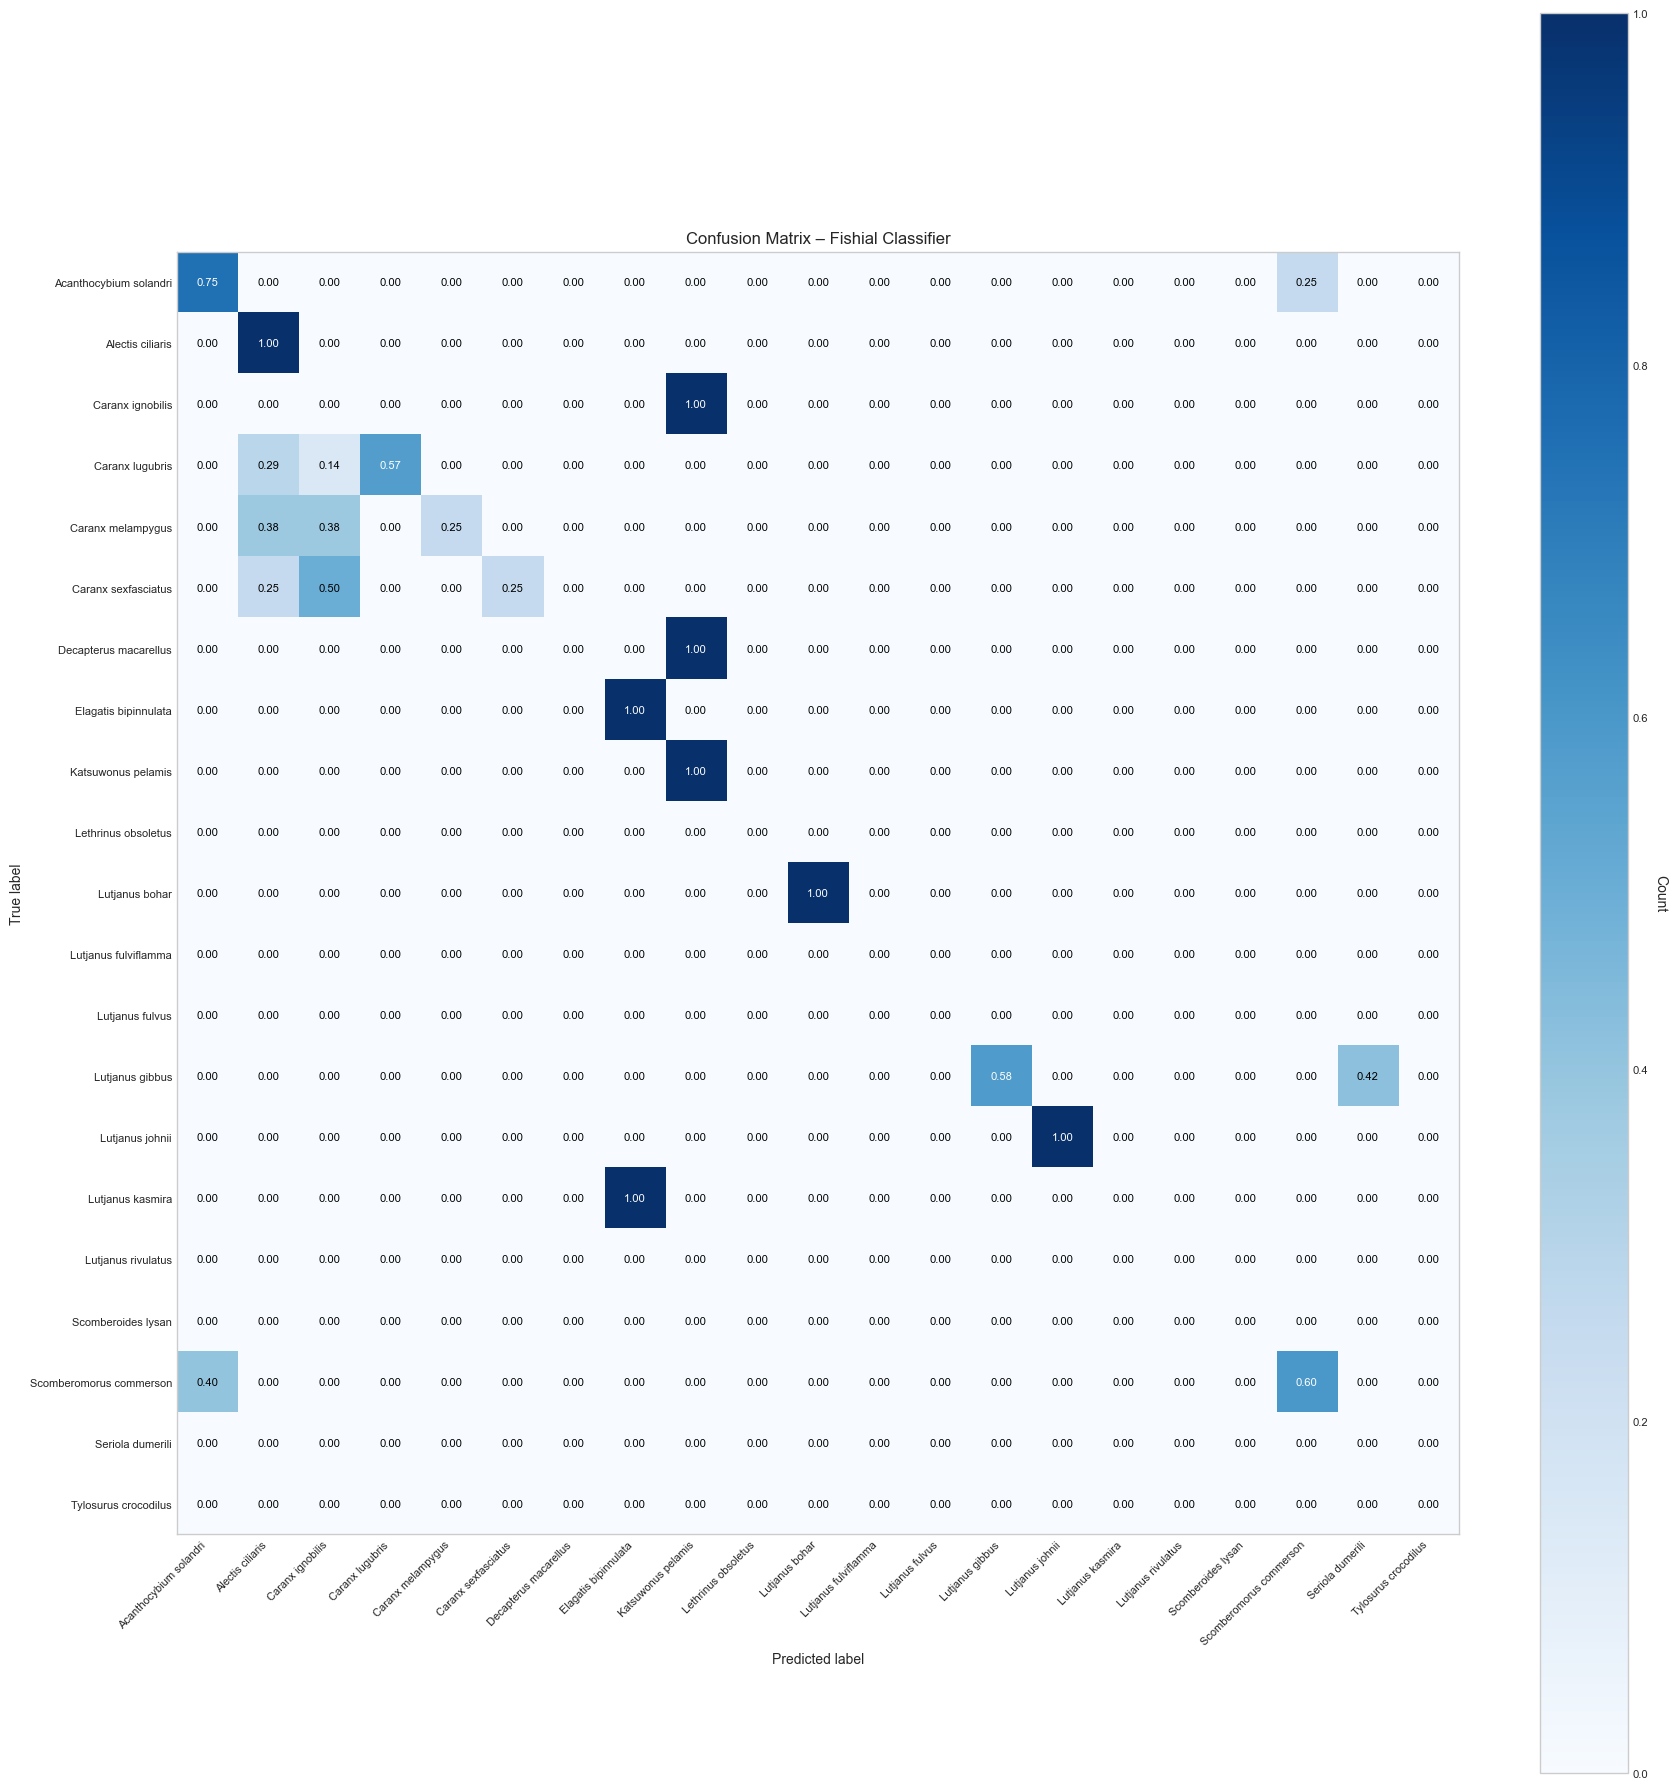

In [56]:

unique_species = sorted(set(y_true))
cm = confusion_matrix(y_true, y_pred, labels=unique_species, normalize="true")


fig, ax = plt.subplots(figsize=(18, 18))

# Heatmap
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
cbar = plt.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# Tick labels
ax.set_xticks(np.arange(len(unique_species)))
ax.set_yticks(np.arange(len(unique_species)))
ax.set_xticklabels(unique_species)
ax.set_yticklabels(unique_species)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix – Fishial Classifier")

# Turn off grid
ax.grid(False)

# --- Add the values in each cell ---
max_val = cm.max() if cm.max() > 0 else 1
# --- Add exact cell values (no rounding) ---
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]

        text_color = "white" if val > cm.max() / 2 else "black"
        ax.text(
            j, i, f"{val:.2f}",   
            ha="center", va="center",
            color=text_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()
